In [2]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

sys.path.append("../scripts")
sys.path.append("..")
 
from extract import *



In [3]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)
table = read_table(path)

#Define a slice of data
DSL = slice(15,80) # depth slice
sl = (slice(0,2000),DSL,slice(0,None),slice(0,None))

#Get state variables
N2 = extract_node(table,'N2')[sl]
T  = extract_node(table,'T')[sl]
S  = extract_node(table,'S')[sl]
R  = extract_node(table,'R')[sl]
W  = extract_node(table,'W')[sl]*100
Z  = extract_node(table,'z').flatten()[sl[1]]
#P  = sw.eos80.pres(Z,30)

#Compute Density from state variables
#RP = sw.eos80.dens(S,T,2000)
#RP  = sw.eos80.pden(S,T,P,pr=0)
#RP  = sw.eos80.dens(S,T,0)


TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Start time at zero
t0 = matlab2datetime(TIME[1]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0)/3600 for T in TIME]

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,LAT,LON])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(T.shape)

In [4]:
"""
Compute means
"""
#Compute the mean stratification
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = np.mean(R,axis=(0,2,3))


#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z)
DZ   = AX['z'] - zofr(R) 

0.1210305958132045 0.2010305958132045


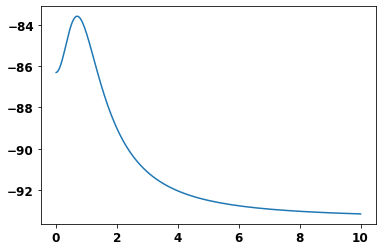

In [5]:
"""
M2 band pass filter
"""
def bandpass_filter(center,half_width,fs,order=5):
    nyq = fs*0.5
    lo = (center-half_width)/nyq
    hi = (center+half_width)/nyq
    print(lo,hi)
    b, a = sig.butter(order, [lo, hi], btype='bandpass')
    return b,a

M2  = 1/12.42 #.0805 
#M2 = 1/24
bw  = .02
b,a = bandpass_filter(M2,bw,1)
DZB = sig.lfilter(b,a,DZ,axis=0)
RPB = sig.lfilter(b,a,R,axis=0)
WB = sig.lfilter(b,a,W,axis=0)

w, h = sig.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))


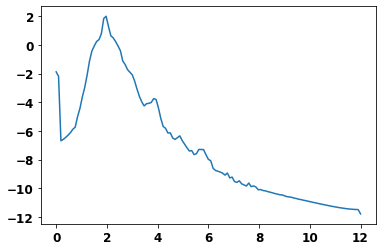

In [6]:
f,pxx = sig.welch(DZB[:,8,9,8],fs=24)
plt.plot(f,np.log10(pxx))

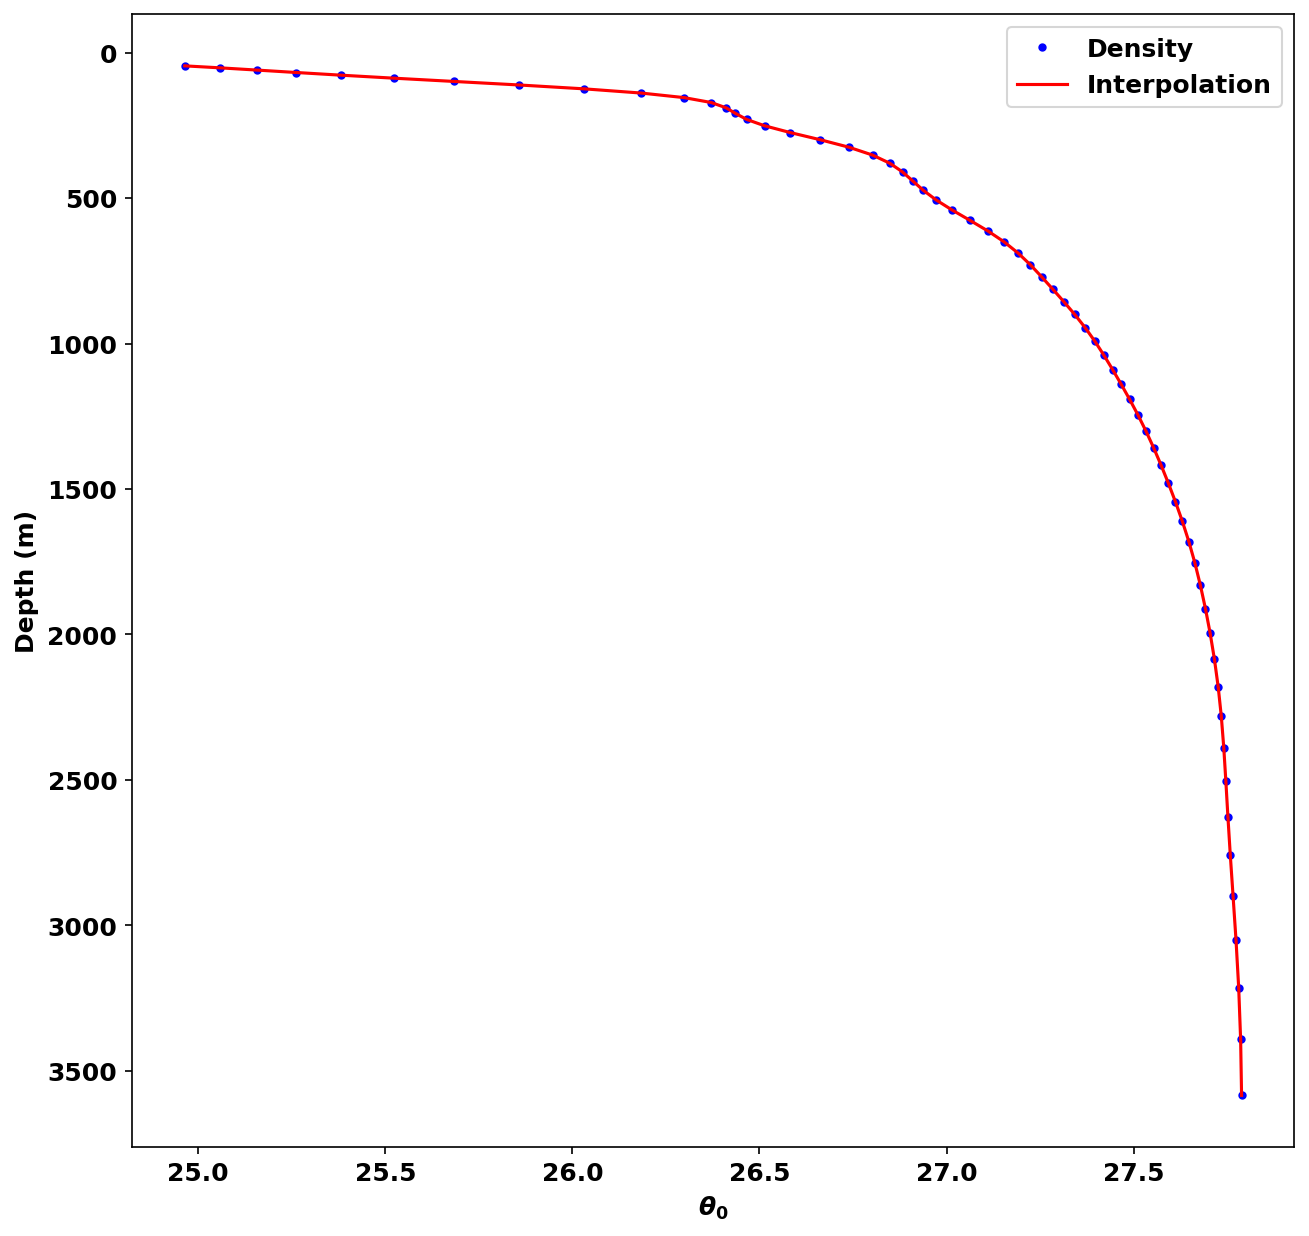

In [7]:
%matplotlib inline
f, ax = plt.subplots()
zofr_p = zofr.derivative()
ax.plot(R_mean,Z,'b.',  label='Density',)
ax.plot(R_mean,zofr(R_mean),'r-',label='Interpolation')
ax.invert_yaxis()
ax.set_xlabel(r"$\theta_{0}$")
ax.set_ylabel(r"Depth (m)")
ax.legend()
f.set_size_inches(10,10)
f.set_dpi(150)

Text(0, 0.5, 'Depth [m]')

/home/jpdef/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/home/jpdef/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


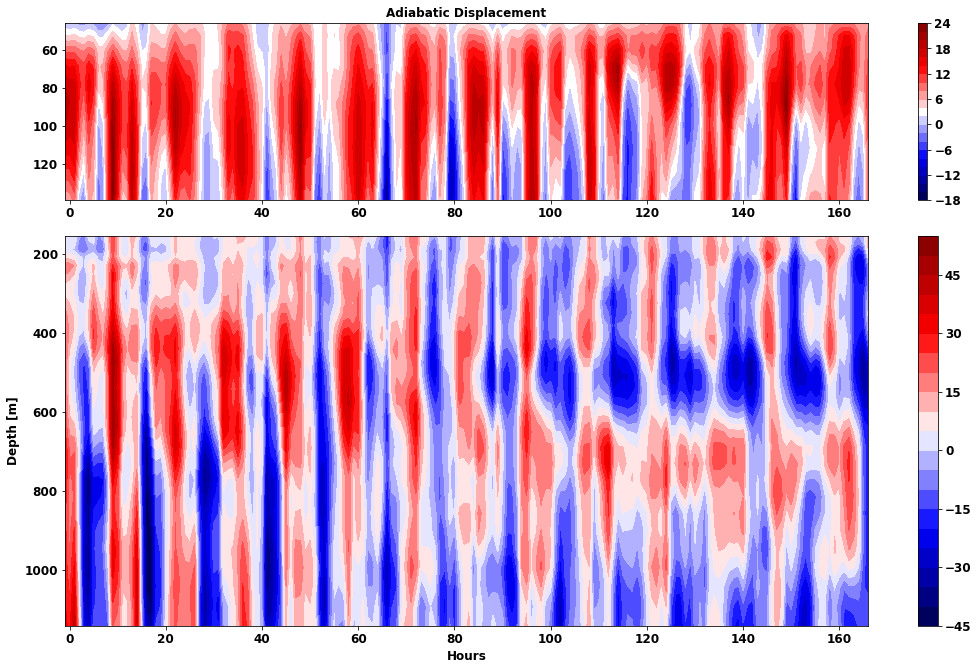

In [8]:
import matplotlib
import cmocean
fig = plt.figure(constrained_layout=True,figsize=(18,15))
spec = matplotlib.gridspec.GridSpec(ncols=1, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1:3, 0])


p1 = ax1.contourf(AX[:168,:10,0,0]['t'].T,AX[:168,:10,0,0]['z'].T,DZ[:168,:10,0,0].T,levels=20,cmap='seismic')
#ax1.contour(AX[:168,:10,0,0]['t'].T,AX[:168,:10,0,0]['z'].T,DZ[:168,:10,0,0].T,levels=20,colors='k')
ax1.invert_yaxis()

p2= ax2.contourf(AX[:168,10:40,0,0]['t'].T,AX[:168,10:40,0,0]['z'].T,DZ[:168,10:40,0,0].T,levels=20,cmap='seismic')
#ax2.contour(AX[:168,10:40,0,0]['t'].T,AX[:168,10:40,0,0]['z'].T,DZ[:168,10:40,0,0].T,levels=20,colors='k')

ax2.invert_yaxis()
f.colorbar(p2,ax=ax2)
f.colorbar(p1,ax=ax1)
ax1.set_title('Adiabatic Displacement')
ax2.set_xlabel('Hours')
ax2.set_ylabel('Depth [m]')


(1999, 5)


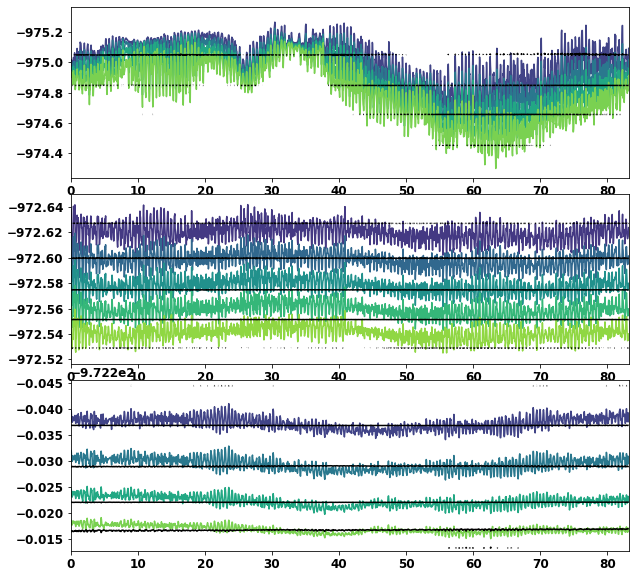

In [9]:
f =  plt.figure()
gs = matplotlib.gridspec.GridSpec(ncols=1,nrows=6,figure=f)
ax0 = f.add_subplot(gs[0:2,0])
ax1 = f.add_subplot(gs[2:4,0])
ax2 = f.add_subplot(gs[4:6,0])
s1 = (slice(0,-1),slice(0,4),0,0)
s2 = (slice(0,-1),slice(35,40),0,0)
s3 = (slice(0,-1),slice(-6,-1),0,0)
ax0.contour(AX[s1]['t']/24,R[s1]-1000,AX[s1]['z'],levels=4)
ax0.contour(AX[s1]['t']/24,R[s1]-1000,zofr(R[s1]),levels=4,colors='k')

ax1.contour(AX[s2]['t']/24,R[s2]-1000,AX[s2]['z'],levels=5)
ax1.contour(AX[s2]['t']/24,R[s2]-1000,zofr(R[s2]),levels=5,colors='k')

ax2.contour(AX[s3]['t']/24,R[s3]-1000,AX[s3]['z'],levels=5)
ax2.contour(AX[s3]['t']/24,R[s3]-1000,zofr(R[s3]),levels=5,colors='k')
#p = ax1.contourf(AX[s2]['t'],np.tile(R_mean[55:59],(200,1)),np.tile(Z[55:59],(200,1)),levels=10)


#p=ax.contourf(AX[s]['t'],R[s],AX[s]['z'],levels=50,cmap='jet')
#p=ax.contourf(AX[s]['t'],AX[s]['z'],np.tile(R_mean[s[1]],(700,1)),levels=20)
ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
#f.colorbar(p)
#f.autofmt_xdate(rotation=70)
f.set_size_inches(10,10)
print(R[s2].shape)

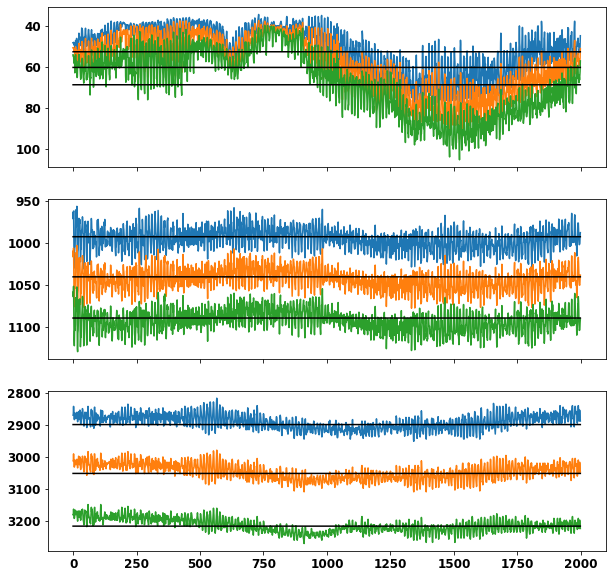

In [10]:
f , ax = plt.subplots(3,1,sharex=True)
ax[0].plot(zofr(R[s1][:,1:4]))
ax[0].plot(AX[s1]['z'][:,1:4],'k-')

ax[1].plot(zofr(R[s2][:,1:4]))
ax[1].plot(AX[s2]['z'][:,1:4],'k-')

ax[2].plot(zofr(R[s3][:,1:4]))
ax[2].plot(AX[s3]['z'][:,1:4],'k-')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

f.set_size_inches(10,10)

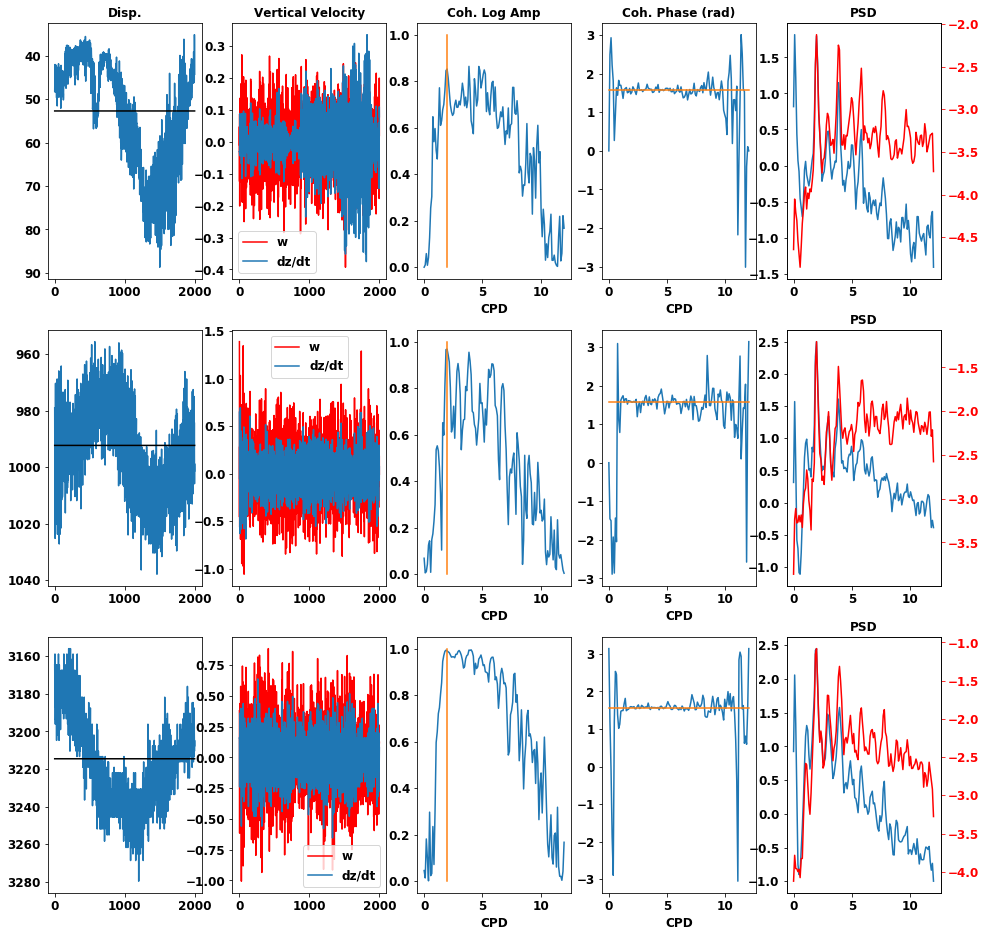

In [11]:
def dz_vs_w(ax1,ax2,ax3,ax4,ax5,DZ,W,sl):
    ZZ = AX[sl]['z'] - DZ[sl]
    ax1.plot(ZZ)
    ax1.plot(AX['z'][sl],'k-')
    ax1.invert_yaxis()
    ax2.plot(W[sl],'r',label='w')
    ax2.plot((1/36)*np.gradient(ZZ.flatten()),label='dz/dt' )
    ax2.legend() 
    f, Cxy = sig.coherence(ZZ.flatten(),W[sl].flatten(),fs=24)
    f, Pxy = sig.csd(ZZ.flatten(),W[sl].flatten(),fs=24)
    ax3.plot(f,Cxy)
    ax3.plot(2*np.ones(5),np.linspace(0,1,5))
    ax3.set_xlabel('CPD')
    ax4.plot(f,np.arctan2(Pxy.imag,Pxy.real))
    ax4.plot(f,1.57*np.ones(len(f)))
    ax4.set_xlabel('CPD')
    f, Pxx = sig.welch(ZZ.flatten(),fs=24)
    f, Pyy = sig.welch(W[sl].flatten(),fs=24)
    ax5.plot(f,np.log10(Pxx))
    ax5.set_title('PSD')
    axt = ax5.twinx()
    axt.plot(f,np.log10(Pyy),'r')
    axt.yaxis.label.set_color('red')
    axt.tick_params(axis='y', colors='red')
    


    
#s1 = (slice(0,256),slice(1,2),9,10)
#s2 = (slice(0,256),slice(36,37),9,10)
#s3 = (slice(0,256),slice(-3,-2),9,10)

s1 = (slice(0,None),slice(1,2),5,8)
s2 = (slice(0,None),slice(36,37),5,8)
s3 = (slice(0,None),slice(-3,-2),5,8)



f ,ax = plt.subplots(3,5)
dz_vs_w(ax[0,0],ax[0,1],ax[0,2],ax[0,3],ax[0,4],DZ,W,s1)
dz_vs_w(ax[1,0],ax[1,1],ax[1,2],ax[1,3],ax[1,4],DZ,W,s2)
dz_vs_w(ax[2,0],ax[2,1],ax[2,2],ax[2,3],ax[2,4],DZ,W,s3)
ax[0,0].set_title('Disp.',)
ax[0,1].set_title('Vertical Velocity',)
ax[0,2].set_title('Coh. Log Amp')
ax[0,3].set_title('Coh. Phase (rad)')
f.set_size_inches(16,16)

#
#f , ax = plt.subplots(3,2,sharex=True)
#dz_vs_w(ax[0,0],ax[0,1],DZB,WB,s1)
#dz_vs_w(ax[1,0],ax[1,1],DZB,WB,s2)
#dz_vs_w(ax[2,0],ax[2,1],DZB,WB,s3)
#f.set_size_inches(10,10)


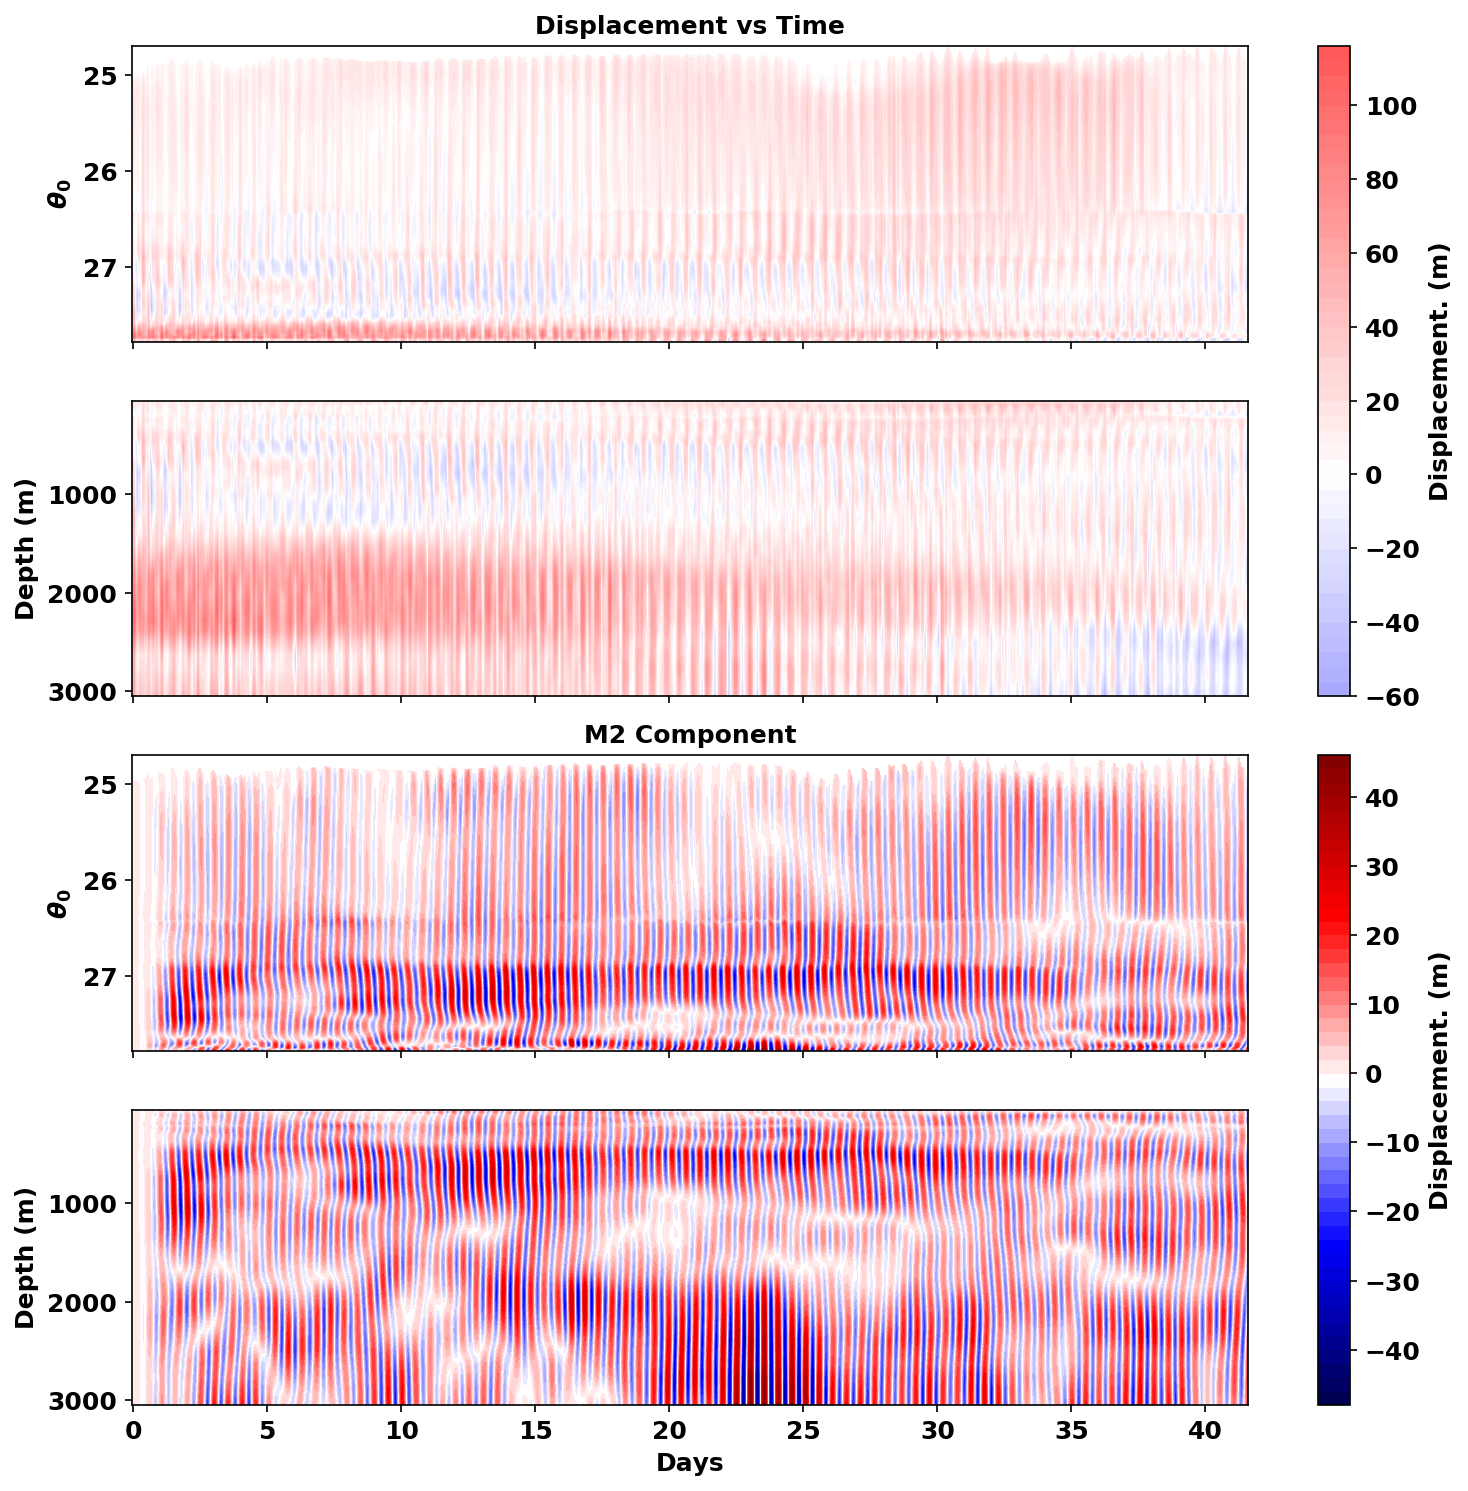

In [12]:
f,ax = plt.subplots(4,1,sharex=True)
s = (slice(0,1000),slice(0,-3),0,0)
p0=ax[0].contourf(AX[s]['t']/24,R[s],DZ[s],levels=50,cmap='seismic',vmin=-350,vmax=350)
p1=ax[1].contourf(AX[s]['t']/24,AX[s]['z'],DZ[s],levels=50,cmap='seismic',vmin=-350,vmax=350)
p2=ax[2].contourf(AX[s]['t']/24,R[s],DZB[s],levels=50,cmap='seismic')
p3=ax[3].contourf(AX[s]['t']/24,AX[s]['z'],DZB[s],levels=50,cmap='seismic')

for a in ax.ravel():
    a.invert_yaxis()

ax[0].set_title("Displacement vs Time")
ax[0].set_ylabel(r'$\theta_0$')
ax[1].set_ylabel('Depth (m)')

ax[2].set_title("M2 Component")
ax[2].set_ylabel(r'$\theta_0$')
ax[3].set_ylabel('Depth (m)')
ax[3].set_xlabel('Days')
f.colorbar(p0,ax=ax[:2],label="Displacement. (m)")
f.colorbar(p2,ax=ax[2:],label="Displacement. (m)")
f.set_size_inches(12,12)
f.set_dpi(150)


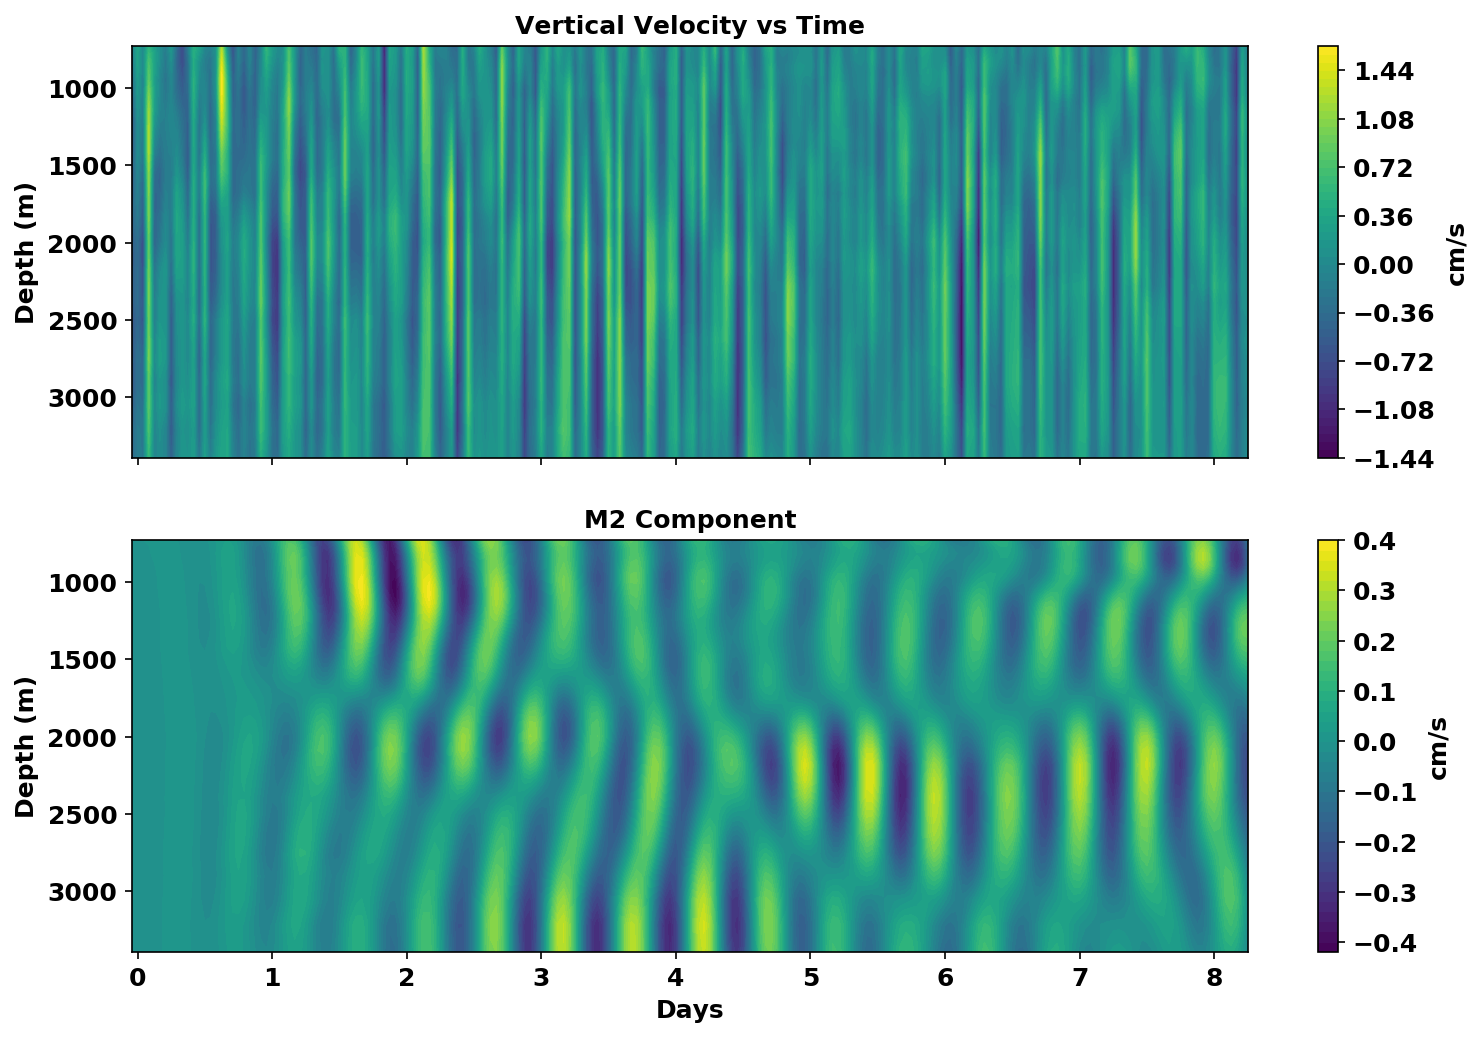

In [13]:
f,ax = plt.subplots(2,1,sharex=True)
s = (slice(0,200),slice(30,-1),0,0)
p0 =ax[0].contourf(AX[s]['t']/24,AX[s]['z'],W[s],levels=50)
p1 = ax[1].contourf(AX[s]['t']/24,AX[s]['z'],WB[s],levels=50)

for a in ax.ravel():
    a.invert_yaxis()
    a.set_ylabel('Depth (m)')
ax[0].set_title('Vertical Velocity vs Time')
ax[1].set_title('M2 Component')
ax[1].set_xlabel('Days')

f.colorbar(p0,ax=ax[0],label='cm/s')
f.colorbar(p1,ax=ax[1],label='cm/s')
f.set_size_inches(12,8)
f.set_dpi(150)


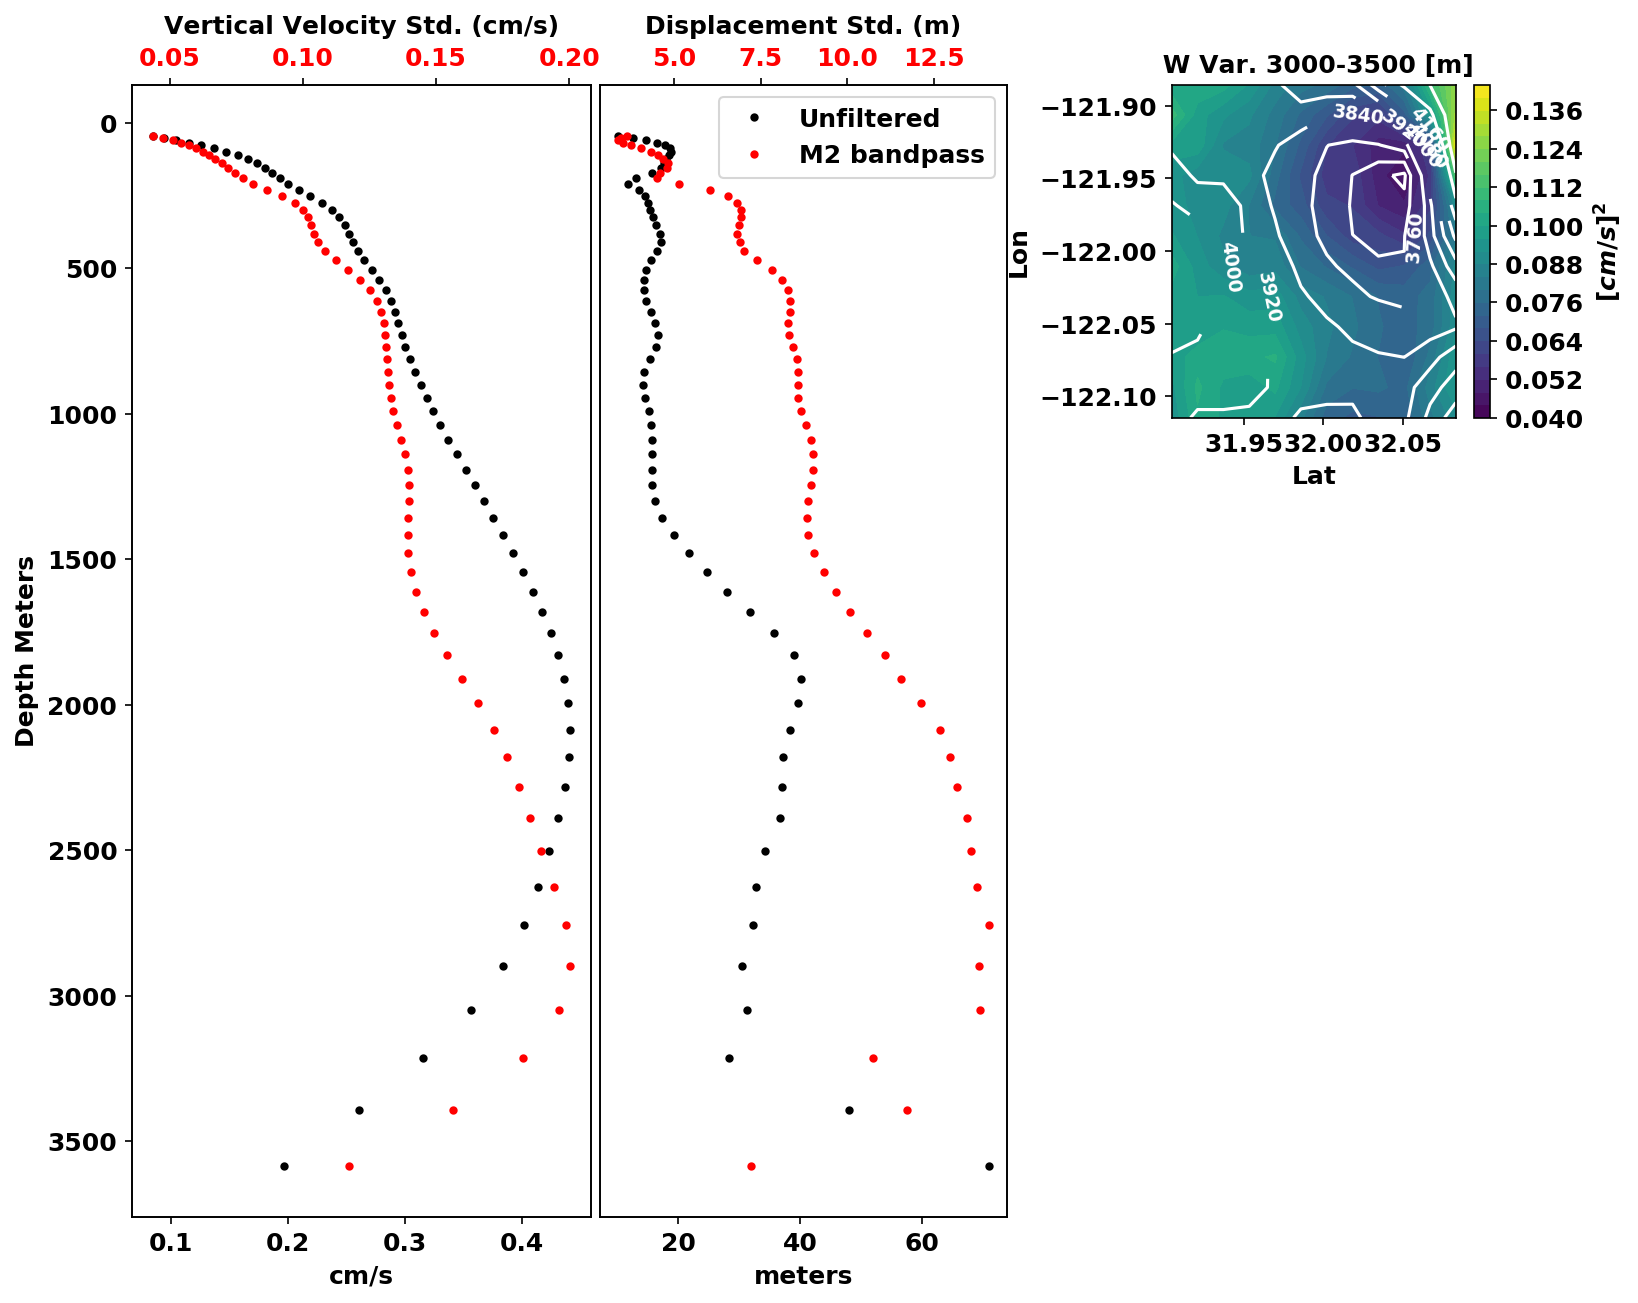

In [14]:

f =  plt.figure()
gs = matplotlib.gridspec.GridSpec(ncols=27,nrows=3,figure=f)
ax0 = f.add_subplot(gs[:,0:9])
ax1 = f.add_subplot(gs[:,9:17])
ax2 = f.add_subplot(gs[:1,20:])

#Plot Vertical Velcoity
ax0.invert_yaxis()
ax0.set_title("Vertical Velocity Std. (cm/s)")
ax0.plot(np.std(W,axis=(0,2,3)),Z,'k.',)
ax0.set_xlabel('cm/s')
ax0.set_ylabel('Depth Meters')
axt0 = ax0.twiny()
axt0.plot(np.std(WB[:,:,0:9,0:9],axis=(0,2,3)),Z,'r.')
axt0.tick_params(axis='x', labelcolor='r')

#Plot Displacement
ax1.invert_yaxis()
ax1.set_title("Displacement Std. (m)")
ax1.set_yticks([])
ln = ax1.plot(np.std(DZ,axis=(0,2,3)),Z,'k.',label='Unfiltered')
ax1.set_xlabel('meters')
axt1 = ax1.twiny()
lnt = axt1.plot(np.std(DZB,axis=(0,2,3)),Z,'r.',label='M2 bandpass')
axt1.tick_params(axis='x', labelcolor='r')
lns = ln + lnt
ax1.legend(lns,[l.get_label() for l in lns],loc=0)

"""Bottom Velocity"""
ax2.set_title(" W Var. 3000-3500 [m]")
#Plot Topo
depth  = extract_node(table,'depth')
lat  = extract_node(table,'lat')
lon  = extract_node(table,'lon')
p = ax2.contour(lat,lon,depth,levels=10,colors='w')
ax2.clabel(p, fontsize=9, inline=1,fmt="%d")
sx = slice(0,None)
sy = slice(0,None)
p = ax2.contourf(lat[sx,sy],lon[sx,sy],np.var(W[:,-3:-1,sx,sy],axis=(0,1)),levels=25)
ax2.set_ylabel('Lon')
ax2.set_xlabel('Lat')
cbar = f.colorbar(p,ax=ax2,label='$[cm/s]^2$')

f.set_size_inches(12,10)
f.set_dpi(150)

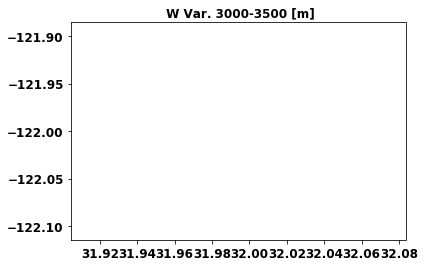

In [15]:
"""Bottom Velocity"""
f,ax = plt.subplots()
ax.set_title(" W Var. 3000-3500 [m]")

#Plot Topo
depth  = extract_node(table,'depth')
lat  = extract_node(table,'lat')
lon  = extract_node(table,'lon')
p = ax.contour(lat,lon,depth,levels=10,colors='w')
ax.clabel(p, fontsize=9, inline=1,fmt="%d")
sx = slice(0,None)
sy = slice(0,None)
p = ax2.contourf(lat[sx,sy],lon[sx,sy],np.var(W[:,-3:-1,sx,sy],axis=(0,1)),levels=25)
ax2.set_ylabel('Lon')
ax2.set_xlabel('Lat')
cbar = f.colorbar(p,ax=ax2,label='$[cm/s]^2$')

In [16]:
print(LAT)
print(LON)

[31.904465 31.920746 31.937027 31.953302 31.969576 31.985847 32.002117
 32.018383 32.034645 32.050903 32.06716  32.083416]
[-122.114586 -122.09375  -122.072914 -122.052086 -122.03125  -122.010414
 -121.989586 -121.96875  -121.947914 -121.927086 -121.90625  -121.885414]


[0 2 3] 65
[0 2 3] 65


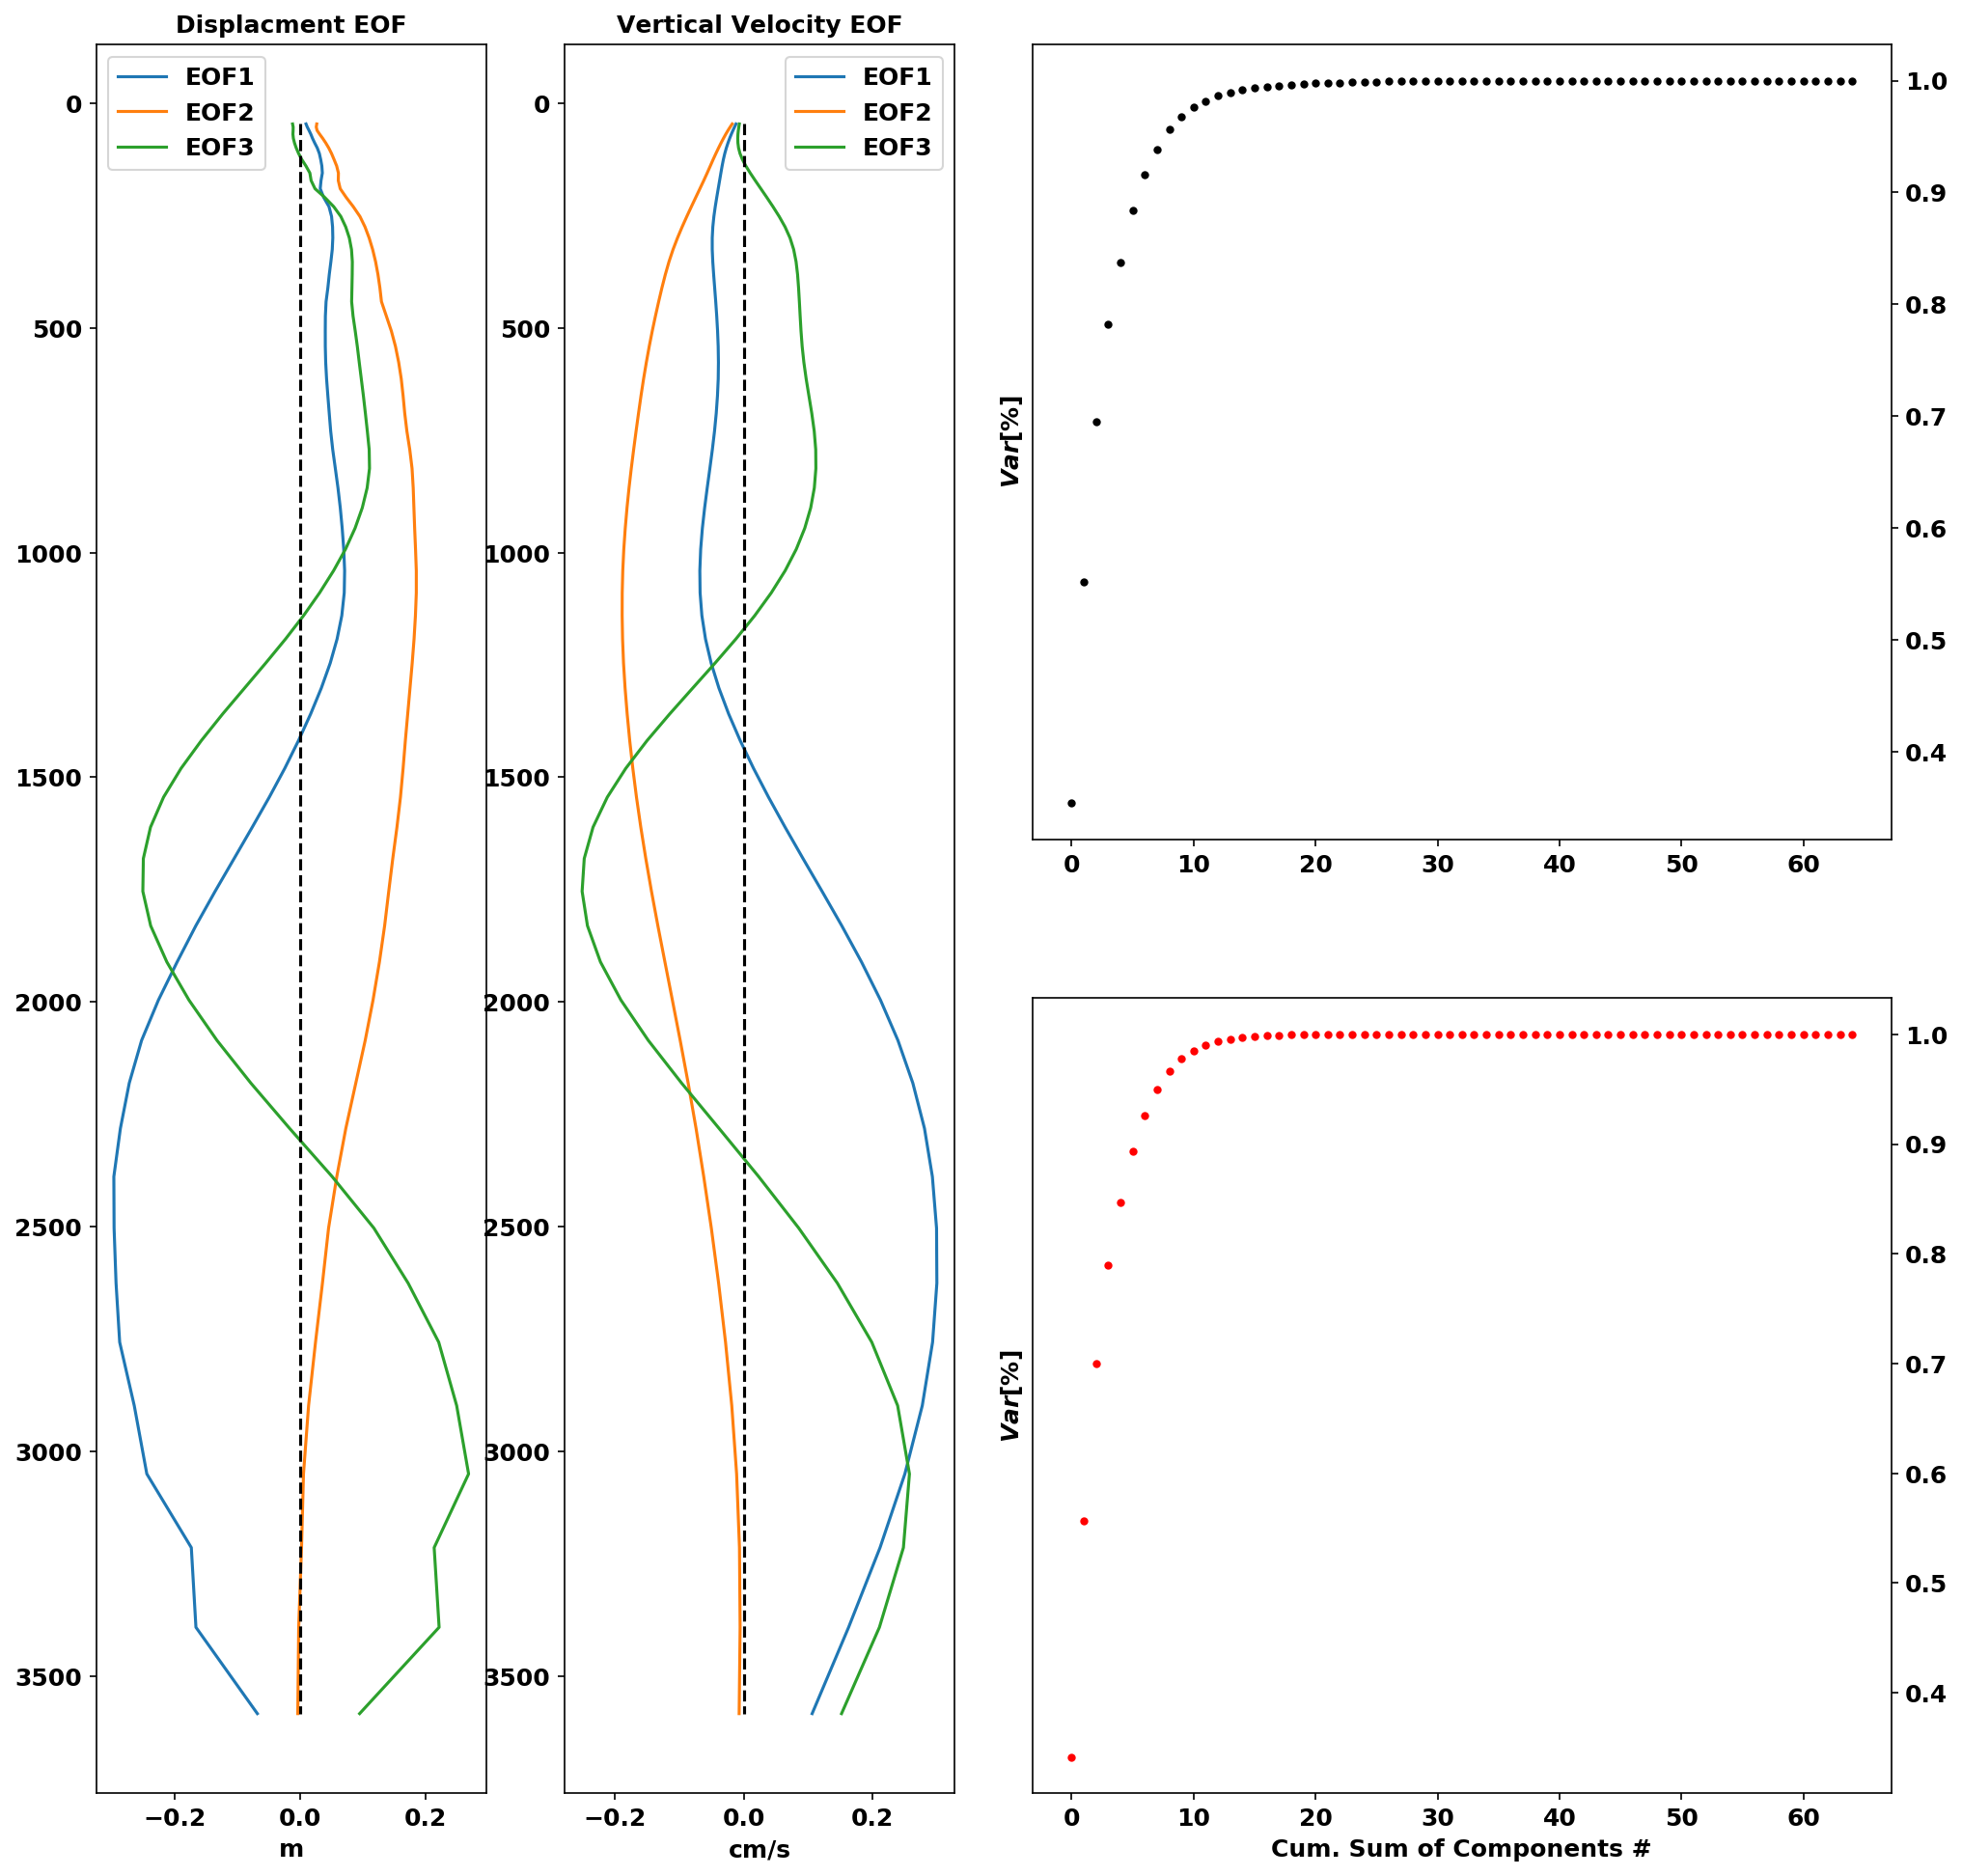

In [17]:
"""
PCA Analysis
"""
%matplotlib inline
from COR.utils import *


#dl,de  = EOF(DZ[:,:,0,0],1)
dl,de  = EOF(DZB,1)
wl,we  = EOF(WB,1)

f  =  plt.figure()
gs = matplotlib.gridspec.GridSpec(2,4)

ax = f.add_subplot(gs[0:2,0])
for i in range(0,3):
    ax.plot(de[:,i],Z,label='EOF%d' % (i+1))
ax.plot(np.zeros(len(Z)),Z,'k--')
ax.set_xlabel("m")
ax.invert_yaxis()
ax.legend()
ax.set_title("Displacment EOF")

ax1 = f.add_subplot(gs[0:2,1])
for i in range(0,3):
    ax1.plot(we[:,i],Z,label='EOF%d' % (i+1))
ax1.plot(np.zeros(len(Z)),Z,'k--')
ax1.set_xlabel("cm/s")
ax1.invert_yaxis()
ax1.legend()
ax1.set_title("Vertical Velocity EOF")

    
ax2 = f.add_subplot(gs[0:1,2:])
#ax2.plot(dl/np.sum(dl),'k.')
ax2.plot(np.cumsum(dl)/np.sum(dl),'k.')
ax2.set_ylabel(r'$Var [\%]$')
ax2.yaxis.tick_right()

ax3 = f.add_subplot(gs[1:,2:])
ax3.plot(np.cumsum(wl)/np.sum(wl),'r.')
ax3.yaxis.tick_right()
ax3.set_ylabel('$Var [\%]$')
ax3.set_xlabel('Cum. Sum of Components #')

f.set_size_inches(16,16)
f.set_dpi(150)

(2000, 65) (65, 65)


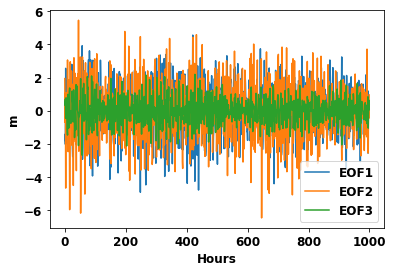

In [18]:
WP = W[:,:,0,0]
print(WP.shape,we.shape)
u = WP @ we
f , ax = plt.subplots()
ax.plot(u[0:1000,0],label="EOF1")
ax.plot(u[0:1000,1],label="EOF2")
ax.plot(u[0:1000,2],label="EOF3")
ax.set_xlabel("Hours")
ax.set_ylabel("m")
ax.legend()
#ax.plot(DZP[0:200,0])

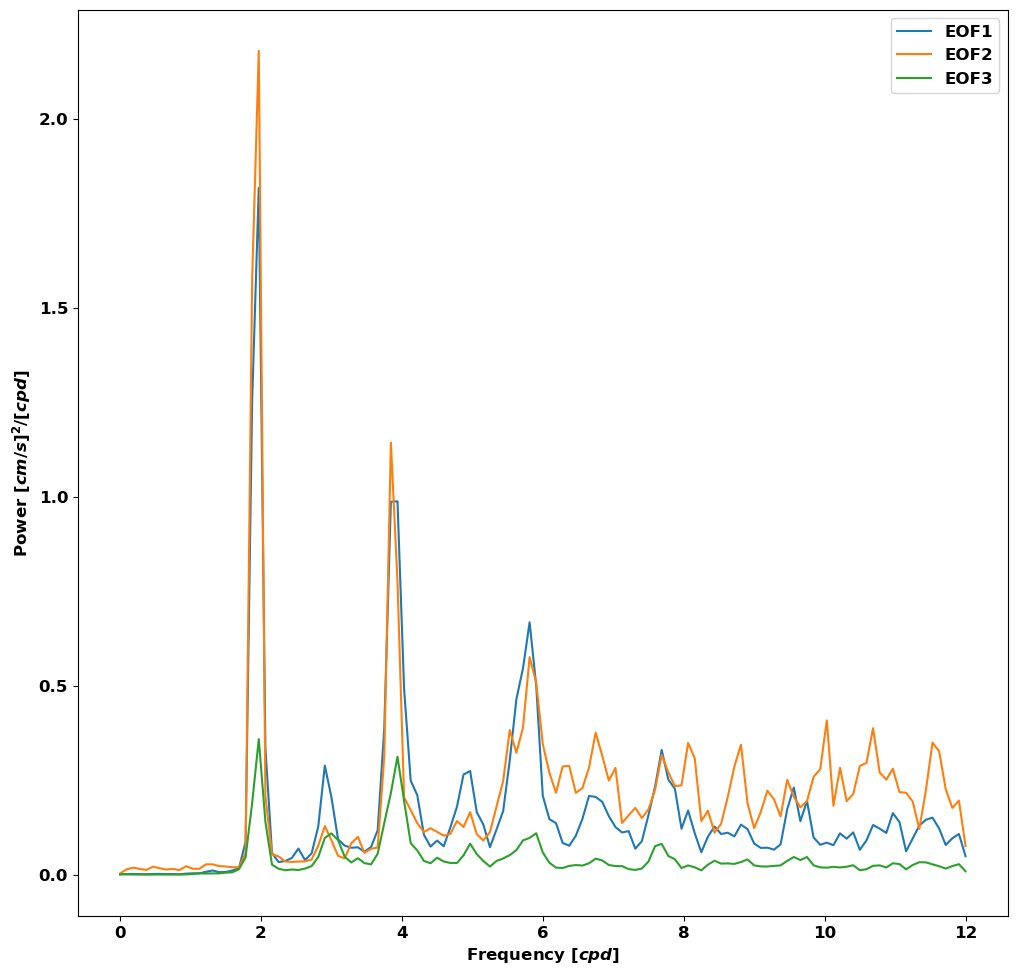

In [19]:
plt.figure(figsize=(12,12),dpi=100)
band = [24*(0.085 - .01), 24*(0.085 + .01)]
for i in range(0,3):
    f,pxx = sig.welch(u[:,i],fs=24)
    plt.plot(f,pxx,label="EOF%i" % (i+1) )
    #plt.scatter(band,[0.02,0.02])
    
plt.xlabel(r'Frequency $[cpd]$')
plt.ylabel(r'Power $[cm/s]^2/[cpd]$')
plt.legend()

In [20]:
UD =  DZ[:,:-3,0,0] @ de

plt.figure(figsize=(12,12),dpi=100)
for i in range(0,3):
    f,pxx = sig.welch(UD[:,i],fs=24)
    plt.plot(f,pxx,label="EOF%i" % (i+1) )
    
plt.xlabel(r'$Frequency [cpd]$')
plt.ylabel(r'$Power [m]^2/[cpd]$')
plt.legend()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 65 is different from 62)